### Imports and version check

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_tuner as kt

c:\Users\hultb\Doom\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### Load CIFAR-100

In [21]:
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

x_train: (50000, 32, 32, 3) y_train: (50000, 1)
x_test: (10000, 32, 32, 3) y_test: (10000, 1)


c:\Users\hultb\Doom\.venv\Lib\site-packages\keras\src\datasets\cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


### Normalize Data

In [22]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# y are already in integer format for sparse_categorical_crossentropy
print("y_train unique samples:", np.unique(y_train[:100])) # check first 100 labels

y_train unique samples: [ 0  1  6  8  9 11 14 15 17 18 19 20 21 22 23 24 27 28 29 31 33 35 36 38
 39 42 43 45 46 47 49 50 51 52 53 55 56 59 64 65 66 69 70 71 72 73 74 75
 76 77 78 80 81 82 83 84 86 87 89 90 92 93 95 96 97 98 99]


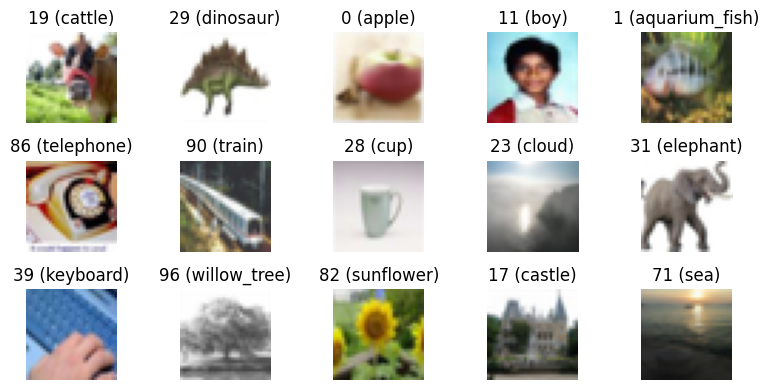

In [38]:
# Print the first 10 images and their labels / class names
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

fig, axes = plt.subplots(3, 5, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i].astype('uint8'))
    ax.set_title(f"{y_train[i][0]} ({class_names[y_train[i][0]]})")
    ax.axis('off')
plt.tight_layout()
plt.show()

### Build the CNN Model

In [23]:
from keras import layers, models

def build_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)), # Input layer

        layers.Conv2D(32, 3, padding='same', activation='relu'), # Conv layer 1
        layers.MaxPooling2D(), # Pooling layer 1

        layers.Conv2D(64, 3, padding='same', activation='relu'), # Conv layer 2
        layers.MaxPooling2D(), # Pooling layer 2

        layers.Conv2D(128, 3, padding='same', activation='relu'), # Conv layer 3
        layers.MaxPooling2D(), # Pooling layer 3

        layers.Flatten(), # Flatten layer to convert 2D to 1D
        layers.Dense(256, activation='relu'), # Fully connected layer
        layers.Dropout(0.5), # Dropout for regularization
        layers.Dense(100, activation='softmax') # Output layer for 100 classes
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_cnn_model()
model.summary() # print model architecture

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 643,492 (2.45 MB)

 Trainable params: 643,492 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

### Train the CNN model

In [31]:
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=128, # samples to process before updating weights
    validation_split=0.2, 
    verbose=2 # print progress bars
)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Baseline model test accuracy: {test_acc:.4f}")

Epoch 1/15
313/313 - 7s - 23ms/step - accuracy: 0.3927 - loss: 2.2691 - val_accuracy: 0.3234 - val_loss: 2.8114
Epoch 2/15
313/313 - 7s - 21ms/step - accuracy: 0.4047 - loss: 2.2142 - val_accuracy: 0.3228 - val_loss: 2.8272
Epoch 3/15
313/313 - 7s - 22ms/step - accuracy: 0.4232 - loss: 2.1323 - val_accuracy: 0.3351 - val_loss: 2.7764
Epoch 4/15
313/313 - 7s - 24ms/step - accuracy: 0.4360 - loss: 2.0659 - val_accuracy: 0.3309 - val_loss: 2.7812
Epoch 5/15
313/313 - 8s - 25ms/step - accuracy: 0.4423 - loss: 2.0272 - val_accuracy: 0.3311 - val_loss: 2.8700
Epoch 6/15
313/313 - 7s - 24ms/step - accuracy: 0.4631 - loss: 1.9498 - val_accuracy: 0.3260 - val_loss: 2.8889
Epoch 7/15
313/313 - 7s - 24ms/step - accuracy: 0.4759 - loss: 1.8820 - val_accuracy: 0.3344 - val_loss: 2.9248
Epoch 8/15
313/313 - 8s - 24ms/step - accuracy: 0.4809 - loss: 1.8635 - val_accuracy: 0.3297 - val_loss: 2.9953
Epoch 9/15
313/313 - 7s - 23ms/step - accuracy: 0.4925 - loss: 1.8085 - val_accuracy: 0.3338 - val_loss:

### Define Model for Tuning

In [25]:
def tuned_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))

    # Block 1
    f1 = hp.Choice("filters_1", [32, 48, 64])
    model.add(layers.Conv2D(f1, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    # Block 2
    f2 = hp.Choice("filters_2", [64, 96, 128])
    model.add(layers.Conv2D(f2, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    # Block 3
    f3 = hp.Choice("filters_3", [96, 128, 160])
    model.add(layers.Conv2D(f3, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())

    dense_units = hp.Choice("dense_units", [128, 256, 512])
    model.add(layers.Dense(dense_units, activation='relu'))

    dropout = hp.Float("dropout_rate", 0.2, 0.6, step=0.1)
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(100, activation='softmax'))

    lr = hp.Float("learning_rate", 1e-4, 3e-3, sampling='log') # 1e-4 to 3e-3 is a good range for learning rates because it covers small to moderate values
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### Run the Hyperparameter search

In [26]:
tuner = kt.Hyperband( # Using Hyperband tuner instead of RandomSearch because it's more efficient because of early stopping
    tuned_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir_cifar100',
    project_name='cifar100_tuning_sample'
)

tuner.search(
    x_train, y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=128,
    verbose=2
)

Reloading Tuner from my_dir_cifar100\cifar100_tuning_sample\tuner0.json


### Train the best tuned model

In [27]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hps.values)

best_model = tuner.hypermodel.build(best_hps)

history_tuned = best_model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    verbose=2
)

test_loss_tuned, test_acc_tuned = best_model.evaluate(x_test, y_test, verbose=0) # verbose=0 to suppress output
print(f"Tuned model test accuracy: {test_acc_tuned:.4f}") # .4f for 4 decimal places

Best hyperparameters: {'filters_1': 32, 'filters_2': 128, 'filters_3': 128, 'dense_units': 512, 'dropout_rate': 0.5, 'learning_rate': 0.00069514089294802, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}
Epoch 1/15
313/313 - 12s - 40ms/step - accuracy: 0.0629 - loss: 4.5984 - val_accuracy: 0.1455 - val_loss: 3.7092
Epoch 2/15
313/313 - 14s - 44ms/step - accuracy: 0.1503 - loss: 3.6284 - val_accuracy: 0.2124 - val_loss: 3.2907
Epoch 3/15
313/313 - 12s - 37ms/step - accuracy: 0.2143 - loss: 3.2695 - val_accuracy: 0.2662 - val_loss: 3.0369
Epoch 4/15
313/313 - 12s - 37ms/step - accuracy: 0.2620 - loss: 3.0068 - val_accuracy: 0.2917 - val_loss: 2.8959
Epoch 5/15
313/313 - 12s - 37ms/step - accuracy: 0.3065 - loss: 2.7735 - val_accuracy: 0.3178 - val_loss: 2.7484
Epoch 6/15
313/313 - 12s - 38ms/step - accuracy: 0.3450 - loss: 2.5740 - val_accuracy: 0.3178 - val_loss: 2.7467
Epoch 7/15
313/313 - 12s - 38ms/step - accuracy: 0.3839 -

In [14]:
print("Baseline model accuracy:", history.history['val_accuracy'][-1])
print("Tuned model accuracy:", history_tuned.history['val_accuracy'][-1])

Baseline model accuracy: 0.4023999869823456
Tuned model accuracy: 0.4404999911785126


### Transfer Learning

In [ ]:
IMG_SIZE = 160 

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

base = tf.keras.applications.EfficientNetB0(
    include_top=False, 
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3) # EfficientNetB0 expects 224x224 images, but we can use smaller sizes
)
base.trainable = False # Train only the top layers initially

inputs = layers.Input(shape=(32, 32, 3))

x = layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs) # Resize CIFAR-100 images to match EfficientNetB0 input size
x = data_augmentation(x) # Apply data augmentation

x = tf.keras.applications.efficientnet.preprocess_input(x) # Preprocess input for EfficientNetB0


x = base(x, training=False) # Pass through base model
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(100, activation='softmax')(x)

tl_model = models.Model(inputs, outputs)

tl_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

tl_model.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │       128,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,177,671 (15.94 MB)

 Trainable params: 128,100 (500.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Train Transfer Learning Head

In [29]:
history_tl = tl_model.fit(
    x_train, y_train,
    epochs=8,
    batch_size=128,
    validation_split=0.2,
    verbose=2
)

test_loss_tl, test_acc_tl = tl_model.evaluate(x_test, y_test, verbose=0)
print(f"Transfer learning model test accuracy: {test_acc_tl:.4f}")

Epoch 1/8
313/313 - 198s - 632ms/step - accuracy: 0.4391 - loss: 2.3913 - val_accuracy: 0.6400 - val_loss: 1.3465
Epoch 2/8
313/313 - 165s - 529ms/step - accuracy: 0.5861 - loss: 1.5441 - val_accuracy: 0.6712 - val_loss: 1.1711
Epoch 3/8
313/313 - 174s - 557ms/step - accuracy: 0.6179 - loss: 1.3980 - val_accuracy: 0.6851 - val_loss: 1.1024
Epoch 4/8
313/313 - 209s - 668ms/step - accuracy: 0.6321 - loss: 1.3226 - val_accuracy: 0.6932 - val_loss: 1.0620
Epoch 5/8
313/313 - 247s - 790ms/step - accuracy: 0.6502 - loss: 1.2575 - val_accuracy: 0.6980 - val_loss: 1.0413
Epoch 6/8
313/313 - 238s - 760ms/step - accuracy: 0.6593 - loss: 1.2122 - val_accuracy: 0.7026 - val_loss: 1.0249
Epoch 7/8
313/313 - 222s - 711ms/step - accuracy: 0.6652 - loss: 1.1836 - val_accuracy: 0.7085 - val_loss: 1.0116
Epoch 8/8
313/313 - 199s - 637ms/step - accuracy: 0.6688 - loss: 1.1588 - val_accuracy: 0.7080 - val_loss: 1.0068
Transfer learning model test accuracy: 0.7157


In [20]:
print(y_train.shape, y_train.min(), y_train.max())

(50000, 1) 0 99


### Fine-tuning

In [ ]:
base.trainable = True

# Unfreeze last 20 layers for fine-tuning
for layer in base.layers[:-20]:
    layer.trainable = False

tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # lower LR for fine-tune
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_ft = tl_model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=2
)

test_loss_ft, test_acc_ft = tl_model.evaluate(x_test, y_test, verbose=0)
print(f"Transfer Learning (fine-tuned) Test Accuracy: {test_acc_ft:.4f}")


Epoch 1/5
313/313 - 186s - 595ms/step - accuracy: 0.6696 - loss: 1.1743 - val_accuracy: 0.7228 - val_loss: 0.9665
Epoch 2/5
313/313 - 213s - 681ms/step - accuracy: 0.7083 - loss: 1.0016 - val_accuracy: 0.7309 - val_loss: 0.9178
Epoch 3/5
313/313 - 185s - 591ms/step - accuracy: 0.7261 - loss: 0.9292 - val_accuracy: 0.7408 - val_loss: 0.8885
Epoch 4/5
313/313 - 196s - 625ms/step - accuracy: 0.7441 - loss: 0.8721 - val_accuracy: 0.7444 - val_loss: 0.8663
Epoch 5/5
313/313 - 188s - 599ms/step - accuracy: 0.7528 - loss: 0.8278 - val_accuracy: 0.7494 - val_loss: 0.8506
Transfer Learning (fine-tuned) Test Accuracy: 0.7634


In [32]:
print("=== Results (Test Accuracy) ===")
print(f"Baseline CNN:                 {test_acc:.4f}")
print(f"Tuned CNN (KerasTuner):       {test_acc_tuned:.4f}")
print(f"Transfer Learning (frozen):   {test_acc_tl:.4f}")
print(f"Transfer Learning (fine-tune):{test_acc_ft:.4f}")

=== Results (Test Accuracy) ===
Baseline CNN:                 0.3364
Tuned CNN (KerasTuner):       0.3736
Transfer Learning (frozen):   0.7157
Transfer Learning (fine-tune):0.7634


In [33]:
baseline = 0.3364
tuned = 0.3736
frozen = 0.7157
finetune = 0.7634

print("=== Improvements (percentage points) ===")
print(f"Tuned vs Baseline:     {(tuned-baseline)*100:.2f} pp")
print(f"Frozen vs Baseline:    {(frozen-baseline)*100:.2f} pp")
print(f"Fine-tune vs Frozen:   {(finetune-frozen)*100:.2f} pp")
print(f"Fine-tune vs Baseline: {(finetune-baseline)*100:.2f} pp")


=== Improvements (percentage points) ===
Tuned vs Baseline:     3.72 pp
Frozen vs Baseline:    37.93 pp
Fine-tune vs Frozen:   4.77 pp
Fine-tune vs Baseline: 42.70 pp


313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 155ms/step


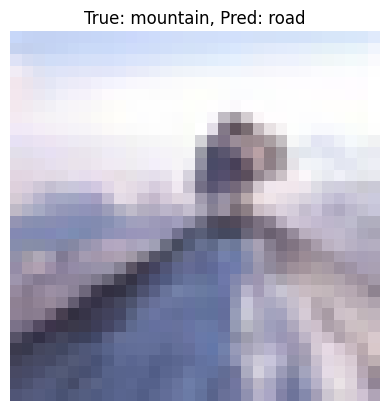

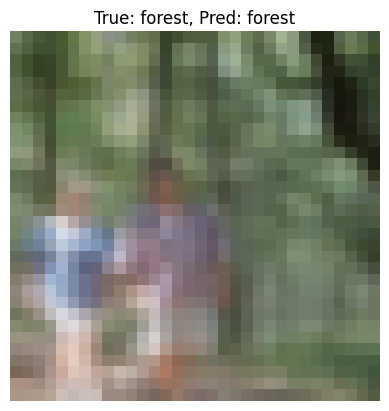

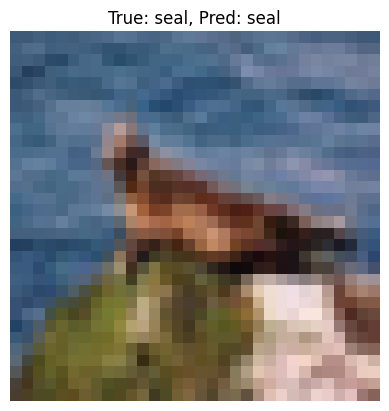

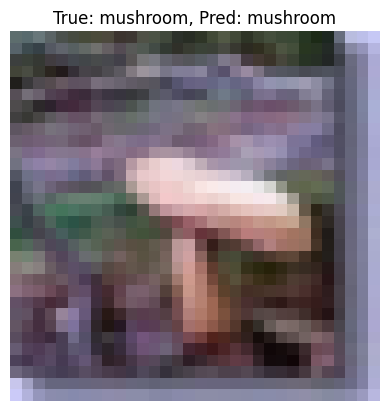

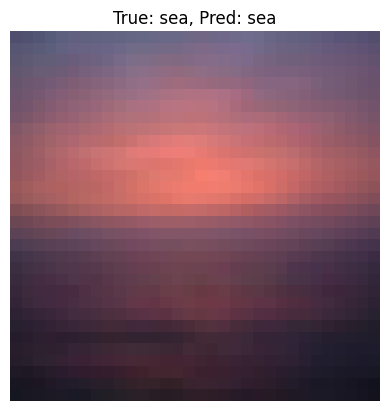

In [39]:
# Predict and show some results
preds = tl_model.predict(x_test)
for i in range(5):
    plt.imshow(x_test[i].astype('uint8'))
    true_label = class_names[y_test[i][0]]
    pred_label = class_names[np.argmax(preds[i])]
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()